In [112]:
import rdkit
import pandas as pd
import torch
from rdkit import Chem
#from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
#IPythonConsole.ipython_useSVG=True
from captum.attr import *
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.utils import accuracy, f1_score
device = 'cpu'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TopKPooling, SAGEConv, EdgePooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp


In [2]:
class Net(nn.Module):
    
    def __init__(self, n_feats):
        super(Net, self).__init__()
        self.atom_embedding = nn.Linear(n_feats, n_feats)
        self.conv1 = SAGEConv(n_feats, n_feats)
        self.pool1 = EdgePooling(n_feats)
        self.conv2 = SAGEConv(n_feats, n_feats)
        self.pool2 = EdgePooling(n_feats)
        self.linear = torch.nn.Linear(2*n_feats, 1)

    def forward(self, x, edge_index, batch=None):
        if len(x.shape) == 3: #NEEDED FOR EXAI, NOTICE THAT IT MUST BE ONLY ONE MOL
            data_list = []
            for x_i, edge_index_i in zip(x, edge_index):
                data_list.append(Data(x=x_i, edge_index=edge_index_i))
            data = Batch.from_data_list(data_list).to(device)
            x = data.x
            batch = data.batch
            edge_index = data.edge_index
        shape = x.shape
        x = x.reshape(-1,shape[-1])
        x = self.atom_embedding(x)
        x = x.reshape(shape)
        x = x.squeeze(1)
        
        x = F.relu(self.conv1(x, edge_index))

        x, edge_index, batch, _ = self.pool1(x, edge_index, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
     
        x, edge_index, batch, _ = self.pool2(x, edge_index, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
        x = x1 + x2
        x = self.linear(x)    
        #x = torch.sigmoid(x)
        x = x.squeeze(1)
        return x



In [3]:
import numpy as np


        
    
    

In [4]:
!ls

CHEMBL_HDAC1_B-r3_b2048.csv		jak2_data.csv
GraphNN.ipynb				logP_dataset.csv
GraphNN_JAK2.ipynb			merge_mols.py
GraphNN_LogP.ipynb			solubility_data.csv
gt_model				untitled.csv
gt_model_logp				Untitled.ipynb
HDAC4_bioactivity-18_18_17_29_IC50.csv


In [5]:
#df = pd.read_csv('CHEMBL_HDAC1_B-r3_b2048.csv')
df = pd.read_csv('solubility_data.csv', header = 0)
# df.columns = ['SMILES', 'logP']

In [6]:
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


In [7]:
df.columns

Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')

In [49]:
import matplotlib.pyplot as plt
#plt.hist(df.pIC50)
#df['act'] = (df.pIC50 > 8.2)*1.0
#df['act'] = (df.logP >= 1) & (df['logP'] <= 4 )
df['logS'] = df['measured log solubility in mols per litre']
df['act'] = df.logS
df['SMILES'] = df.smiles

In [50]:
#df['act'] = df['IS_ACTIVE']

In [51]:
#df['SMILES'] = df['Smiles']
#df = df.dropna()

In [52]:
def try_catch(fn, *args, **kwargs):
    try:
        return fn(*args, **kwargs)
    except Exception as e:
        print(e, *args, **kwargs)
        return None

In [53]:
df.head(15)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,logS,act,SMILES,mol,graph
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f6eb7aab2b0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 2,..."
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,-3.30,-3.30,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x7f6eb7aab120>,"[(edge_index, [tensor([ 0, 1, 1, 1, 2, 2,..."
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),-2.06,-2.06,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x7f6eb7aab1c0>,"[(edge_index, [tensor([ 0, 1, 1, 1, 2, 3,..."
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x7f6eb7aab350>,"[(edge_index, [tensor([ 0, 0, 1, 1, 2, 2,..."
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1,-1.33,-1.33,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x7f6eb7aab850>,"[(edge_index, [tensor([0, 0, 1, 1, 2, 2, 3, 3,..."
5,benzothiazole,-2.733,2,135.191,0,2,0,12.89,-1.50,c2ccc1scnc1c2,-1.50,-1.50,c2ccc1scnc1c2,<rdkit.Chem.rdchem.Mol object at 0x7f6eb7aab7b0>,"[(edge_index, [tensor([0, 0, 1, 1, 2, 2, 3, 3,..."
6,"2,2,4,6,6'-PCB",-6.545,1,326.437,0,2,1,0.00,-7.32,Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl,-7.32,-7.32,Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl,<rdkit.Chem.rdchem.Mol object at 0x7f6eb7ad72b0>,"[(edge_index, [tensor([ 0, 1, 1, 1, 2, 2,..."
7,Estradiol,-4.138,1,272.388,2,4,0,40.46,-5.03,CC12CCC3C(CCc4cc(O)ccc34)C2CCC1O,-5.03,-5.03,CC12CCC3C(CCc4cc(O)ccc34)C2CCC1O,<rdkit.Chem.rdchem.Mol object at 0x7f6eb7ad7300>,"[(edge_index, [tensor([ 0, 1, 1, 1, 1, 2,..."
8,Dieldrin,-4.533,1,380.913,0,5,0,12.53,-6.29,ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl,-6.29,-6.29,ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x7f6eb7ad71c0>,"[(edge_index, [tensor([ 0, 1, 1, 1, 2, 2,..."
9,Rotenone,-5.246,1,394.423,0,5,3,63.22,-4.42,COc5cc4OCC3Oc2c1CC(Oc1ccc2C(=O)C3c4cc5OC)C(C)=C,-4.42,-4.42,COc5cc4OCC3Oc2c1CC(Oc1ccc2C(=O)C3c4cc5OC)C(C)=C,<rdkit.Chem.rdchem.Mol object at 0x7f6eb7ad7760>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 2,..."


In [54]:
CHIRAL_TYPES = len(Chem.rdchem.ChiralType.values)
HYBRIDIZATION_TYPES = len(Chem.rdchem.HybridizationType.values)
atoms = [1,5,6,7,8,9,14,15,16,17,35,53]
seen_atoms = {k:i for i, k in enumerate(sorted(atoms))}

def atm_data(atm):
    atomic_num = atm.GetAtomicNum()
    atomic_num = np.eye(len(seen_atoms))[seen_atoms[atomic_num]]
    chiral = np.eye(CHIRAL_TYPES)[int(atm.GetChiralTag())]
    hybrid = np.eye(HYBRIDIZATION_TYPES)[int(atm.GetHybridization())]
    charge = atm.GetFormalCharge()
    imp_val = atm.GetImplicitValence()
    aromatic = int(atm.GetIsAromatic())
    isotope = atm.GetIsotope()
    mass = atm.GetMass()
    rad_ele = atm.GetNumRadicalElectrons()
    ring = atm.IsInRing()
    data = np.concatenate([atomic_num, [charge,imp_val, aromatic, isotope, mass, rad_ele, ring], chiral, hybrid])
    return data

def gen_graph(mol, act=None):
    #print(act)
    n = mol.GetNumAtoms()
    atoms = []
    #adj = np.zeros((n,n))
    edge_index = []
    for atm in mol.GetAtoms():
        atoms.append(atm_data(atm))
        idx = atm.GetIdx()
        for neig in atm.GetNeighbors():
            neig_idx = neig.GetIdx()
            #adj[idx, neig_idx] = 1
            #adj[neig_idx, idx] = 1
            edge_index.append([idx, neig_idx])
    edge_index = torch.tensor(np.transpose(edge_index)).long()
    #print(edge_index)
    x = torch.tensor(np.array(atoms)).float()
    if act is not None:
        act = torch.tensor([act]).float()
    data = Data(x=x, edge_index=edge_index, y=act)
    return data
df['mol'] = df.apply(lambda row: try_catch(Chem.MolFromSmiles, row['SMILES']), axis=1)
df['graph'] = df.apply(lambda row: gen_graph(row['mol'], row['act']), axis=1)
#df['graph'] = df.apply(gen_graph)


In [55]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, shuffle=True)
df_train = df
df_test = df

In [56]:
train_data = list(df_train.graph)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data = list(df_test.graph)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [57]:
net = Net(19+len(atoms))
net = net.to(device)
#loss = nn.BCELoss()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3)
EPOCHS = 70

In [58]:
losses = []
print('loss, acc, f1')
for epoch in range(EPOCHS):
    net.train()
    stats = np.zeros(3)
    for data in train_loader:
        data = data.to(device)
        x, edge_index, batch = data.x, data.edge_index, data.batch
        y_pred = net(x, edge_index, batch)
        y = data.y.to(device)
        l = loss(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        stats += data.num_graphs * np.array([l.item(), 0, 0])
#         stats += data.num_graphs * np.array([l.item(),accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])
        #stats += data.num_graphs * np.array([l.item()])#,accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])

    losses.append(stats/len(train_data))
    print('train', losses[-1])
    net.eval()
    stats = np.zeros(3)
    for data in test_loader:
        with torch.no_grad():
            data = data.to(device)
            x, edge_index, batch = data.x, data.edge_index, data.batch
            y_pred = net(x, edge_index, batch)
            y = data.y.to(device)
            l = loss(y_pred, y)
            stats += data.num_graphs * np.array([l.item(), 0, 0])
#             stats += data.num_graphs * np.array([l.item(),accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])
            #stats += data.num_graphs * np.array([l.item()])#,accuracy((y_pred>0.5).int(), y), f1_score((y_pred>0.5).int(), y, 1)])
    losses.append(stats/len(test_data))
    print('test', losses[-1])

loss, acc, f1
train [4.75796165 0.         0.        ]
test [4.14422266 0.         0.        ]
train [4.01220511 0.         0.        ]
test [3.78653056 0.         0.        ]
train [4.03136077 0.         0.        ]
test [4.05325964 0.         0.        ]
train [3.68858281 0.         0.        ]
test [3.42966858 0.         0.        ]
train [3.74371338 0.         0.        ]
test [3.84892321 0.         0.        ]
train [3.47753929 0.         0.        ]
test [3.25302159 0.         0.        ]
train [3.17973472 0.         0.        ]
test [3.11556282 0.         0.        ]
train [3.13581081 0.         0.        ]
test [3.05541479 0.         0.        ]
train [3.01880425 0.         0.        ]
test [2.87423354 0.         0.        ]
train [2.85081559 0.         0.        ]
test [2.7588805 0.        0.       ]
train [2.7200913 0.        0.       ]
test [2.52997957 0.         0.        ]
train [2.53370316 0.         0.        ]
test [2.78918411 0.         0.        ]
train [2.8854468 0. 

In [68]:
net

Net(
  (atom_embedding): Linear(in_features=31, out_features=31, bias=True)
  (conv1): SAGEConv(31, 31)
  (pool1): EdgePooling(31)
  (conv2): SAGEConv(31, 31)
  (pool2): EdgePooling(31)
  (linear): Linear(in_features=62, out_features=1, bias=True)
)

In [69]:
torch.save(net, 'gt_model')

<AxesSubplot:>

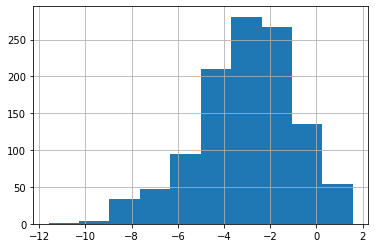

In [73]:
df['measured log solubility in mols per litre'].hist()

In [74]:
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,logS,act,SMILES,mol,graph
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f6eb41f0850>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 2,..."
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,-3.300,-3.300,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x7f6eb41f0940>,"[(edge_index, [tensor([ 0, 1, 1, 1, 2, 2,..."
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),-2.060,-2.060,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x7f6eb41f08f0>,"[(edge_index, [tensor([ 0, 1, 1, 1, 2, 3,..."
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x7f6eb41f09e0>,"[(edge_index, [tensor([ 0, 0, 1, 1, 2, 2,..."
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,-1.330,-1.330,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x7f6eb41f0a30>,"[(edge_index, [tensor([0, 0, 1, 1, 2, 2, 3, 3,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,-1.710,-1.710,FC(F)(F)C(Cl)Br,<rdkit.Chem.rdchem.Mol object at 0x7f6eb414b030>,"[(edge_index, [tensor([0, 1, 1, 1, 1, 2, 3, 4,..."
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x7f6eb414b080>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 2,..."
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,-3.091,-3.091,CCSCCSP(=S)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x7f6eb414b0d0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,-3.180,-3.180,CCC(C)C,<rdkit.Chem.rdchem.Mol object at 0x7f6eb414b120>,"[(edge_index, [tensor([0, 1, 1, 2, 2, 2, 3, 4]..."


In [156]:
def visualize(smiles_list, net, method, ys=None, display=False):
    explains = []
    th_min = float('inf')
    th_max = -float('inf')
    acts = []
    mols = []
    
    explainator = method(net) 
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        data = gen_graph(mol)
        attributions = explainator.attribute(data.x.unsqueeze(0).to(device),
                                                         #baselines=torch.zeros_like(data.x).unsqueeze(0).to(device),
                                                         additional_forward_args=(data.edge_index.unsqueeze(0).to(device),),
                                                         #method='gausslegendre',
                                                         #internal_batch_size=1,  #NEEDED in IG, OTHERWISE FUCKS UP
                                                       )
        explain = attributions.squeeze(0)
        batch = Batch.from_data_list([data]).to(device)
        out = net(batch.x, batch.edge_index, batch.batch)
        acts.append(out.item())
        mols.append(mol)
        explain = explain.mean(-1).detach().cpu().numpy()
        explains.append(explain)
        th_min = min(np.min(explain), th_min)
        th_max = max(np.max(explain), th_max)

    
    vmin = th_min
    vmax = th_max

    l = []
    for explain, mol in zip(explains, mols):
        explain = (explain - vmin)/(vmax - vmin) * 100

        atoms = explain
        highlightMap = {}
        for i, score in enumerate(atoms):
            r, b = 0, 0
            if score > 50:
                r = (score-50)/50
            else:
                b = score/50

            highlightMap[i] = [r, 0, b]
        #print(highlightMap)
        l.append(Draw.MolToImage(mol, size=(300, 300), highlightMap=highlightMap))
    
    if display:
        for i, (elem, act) in enumerate(zip(l, acts)):
            print(act)
            if ys:
                print(ys[i])
            display(elem)
    
    return list(zip(l, acts))

In [1]:
METHODS = {
        "Integrated Gradients": IntegratedGradients,
        "Deep Lift": DeepLift,
        "Gradients": Saliency,
        "Input X Gradients": InputXGradient,
        "Guided Backprop": GuidedBackprop,
    }
#MOLS = ['CC(C)=CCCC(C)=CC(=O)', 'CC(O)=CCCC(C)=CC=O', 'CC(C)=CCCC(C)=CC']
MOLS = ['CCCCC', 'CCCCO']

explainations = {}
for name, method in METHODS.items():
    imgs = visualize(MOLS, net, method)
    explainations[name] = imgs

NameError: name 'IntegratedGradients' is not defined

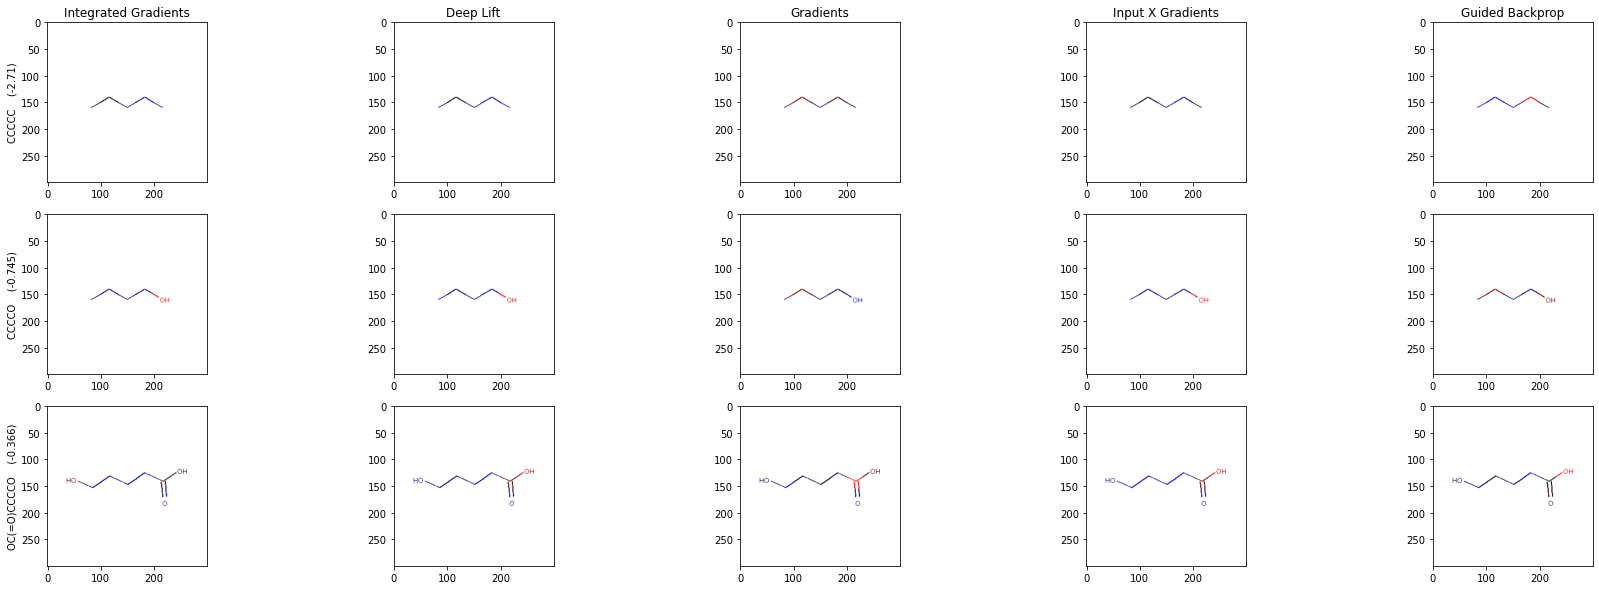

In [180]:
fig, ax = plt.subplots(len(MOLS), len(METHODS), figsize=(10*len(MOLS), 2*len(METHODS)))

for i, (name, imgs) in enumerate(explainations.items()):
    for j, (img, act) in enumerate(imgs):
        ax[j,i].imshow(img)
        ax[j,0].set_ylabel(f"{MOLS[j]}    ({act:.3})")
    ax[0,i].set_title(name)

plt.show()